In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Trip Dates

#### 4/6/2017 - 4/11/2017

# Exploratory Climate Analysis

In [11]:
# Inspect the Tables & Get the column names

inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

print(" ")
print(' ^ Here are the column names for the measurement table')
print('''''')


station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

print(" ")
print(' ^ Here are the column names for the station table')
print('''''')
print('''''')


print('''Measurement Table Data by Date in Descending Order''')
print('''--------------------------------------------------''')
print(''' id        station        date       prcp  tobs''')
engine.execute('SELECT * FROM measurement ORDER BY date DESC').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
 ^ Here are the column names for the measurement table

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
 
 ^ Here are the column names for the station table


Measurement Table Data by Date in Descending Order
--------------------------------------------------
 id        station        date       prcp  tobs


[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0),
 (19548, 'USC00516128', '2017-08-21', 0.56, 76.0),
 (2721, 'USC00519397', '2017-08-20', 0.0, 81.0),
 (7633, 'USC00514830', '2017-08-20', 0.01, 80.0),
 (19547, 'USC00516128', '2017-08-20', None, 78.0),
 (2720, 'USC00519397', '2017-08-19', 0.0, 79.0),
 (7632, 'USC00514830', '2017-08-19', 0.0, 80.0),
 (12184, 'USC00519523', '2017-08-19', None, 85.0),
 (19546, 'USC00516128', '2017-08-19', 0.09, 71.0),
 (2719, 'USC00519397', '2017-08-18', 0.0, 80.0),
 (7631, 'USC00514830', '2017-08-18', 0.0, 77.0),
 (

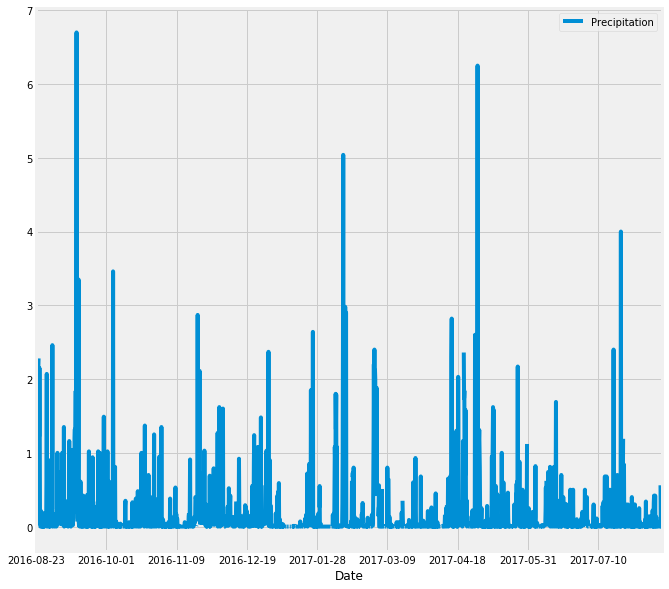

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#-----------------------------------------------------------------------------------------

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns= ['Date','Precipitation'])
prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_index().head(10)

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(figsize=(10,10))



![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Measurement.station).distinct().count()
print(f"There are {station_num} stations available in this dataset.")

There are 9 stations available in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

active_stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                    .filter(Measurement.station == 'USC00519281')
station_temp_data.all()


[(54.0, 85.0, 71.66378066378067)]

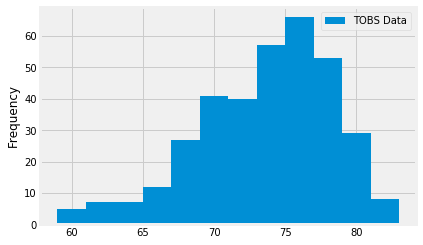

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the tobs data
tobs_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').filter(Measurement.station == 'USC00519281').all()

# Creat a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_results, columns=['Station','TOBS Data'])

# Set the index to Station Column
tobs_df.set_index('Station')

# Plot the histogram
tobs_df.plot(kind= 'hist', bins=12)


In [18]:
session.query(Measurement.date).\
    order_by(Measurement.date.asc()).first()


('2010-01-01')

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calc_temps('2017-04-06', '2017-04-11')
tmin, tavg, tmax = calc_temps('2017-04-06', '2017-04-11')[0]

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


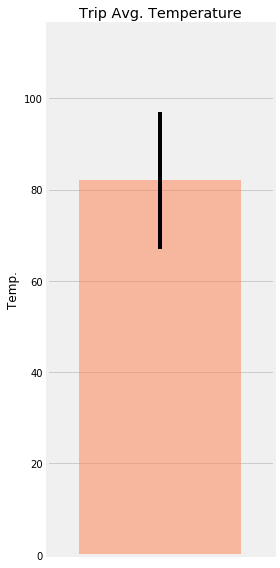

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))


x = 1
yerr = tmax - tmin

bar = ax.bar(x,tmax,yerr= yerr, color= "coral",align="center", alpha= .50)
ax.margins(.2,.2)
ax.set(xticks=range(x),xticklabels="a",title="Trip Avg. Temperature",ylabel="Temp.")

fig.tight_layout()
fig.show()

In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2016-04-06"
end_date = "2016-04-11"

sel = [Station.station, Station.name, Station.latitude, Station.longitude,\
       Station.elevation, func.sum(Measurement.prcp)]

result = session.query(*sel).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(result)



[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.46), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.16), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


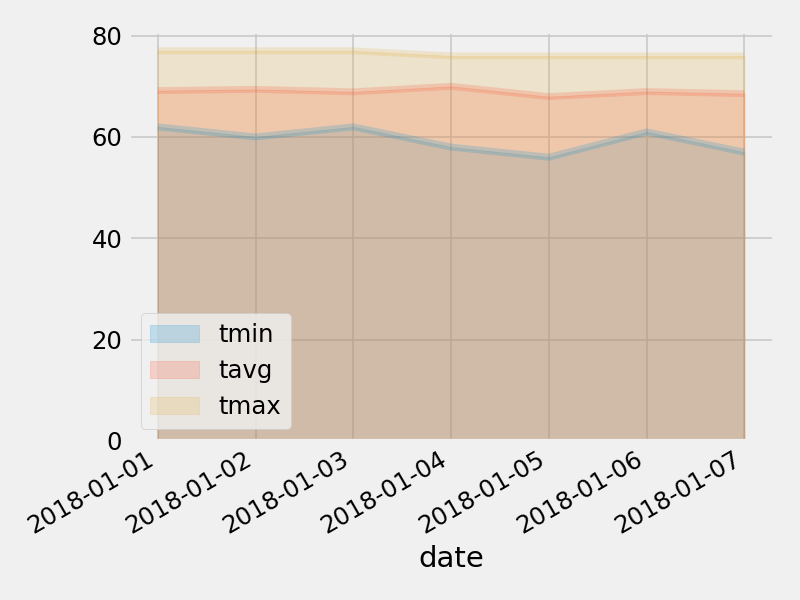

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
